In [1]:
#資料讀取
#from google.colab import files
import pandas as pd
#upload = files.upload()
train_data = pd.read_csv("Train_AQI.csv")
test_data = pd.read_csv("Test_AQI.csv")

In [2]:
#套件載入
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM,Flatten
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error

In [3]:
#NO2欄位統計分析
train_data['NO2(GT)'].describe()

count    3996.000000
mean       78.640390
std        48.652959
min         0.000000
25%        47.000000
50%        84.000000
75%       114.000000
max       233.000000
Name: NO2(GT), dtype: float64

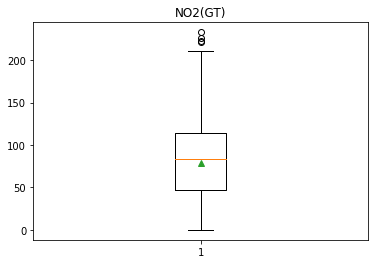

In [4]:
#繪製NO2盒形圖
plt.boxplot(train_data['NO2(GT)'],showmeans=True)
plt.title('NO2(GT)')
plt.show()

In [5]:
#利用IOR刪除離群值
print ("Shape Of The Before Ouliers: ",train_data['NO2(GT)'].shape)
n=1.5
IQR = np.percentile(train_data['NO2(GT)'],75) - np.percentile(train_data['NO2(GT)'],25)
train_data=train_data[train_data['NO2(GT)'] < np.percentile(train_data['NO2(GT)'],75)+n*IQR]
train_data=train_data[train_data['NO2(GT)'] > np.percentile(train_data['NO2(GT)'],25)-n*IQR]
print ("Shape Of The After Ouliers: ",train_data['NO2(GT)'].shape)

Shape Of The Before Ouliers:  (3996,)
Shape Of The After Ouliers:  (3992,)


In [6]:
#刪除離群值後將N02資料格式轉換為DataFrame
training_set=pd.DataFrame(train_data['NO2(GT)'])
training_set

,NO2(GT)
0,113
1,92
2,114
3,122
4,116
...,...
3991,50
3992,34
3993,0
3994,21


In [7]:
#正規化
mm=MinMaxScaler(feature_range=(0,1))
training_set_mm=mm.fit_transform(training_set)

In [8]:
#設定訓練資料的timestep
x_train=[]
y_train=[]
for i in range(48,3992):
    x_train.append(training_set_mm[i-48:i,0])
    y_train.append(training_set_mm[i,0])
x_train,y_train=np.array(x_train),np.array(y_train)

In [9]:
#將資料升維(二維升三維(aqi,timesteps,indicators))
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

In [10]:
#設定callbacks
earlystop=EarlyStopping(monitor='val_loss',patience=2)

In [11]:
#模型建立
model=Sequential()
model.add(LSTM(units=48,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=192,return_sequences=True))
model.add(Flatten())
model.add(Dense(48))
model.add(Dense(1))

model.compile(loss='mean_squared_error',optimizer='SGD',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48, 48)            9600      
                                                                 
 lstm_1 (LSTM)               (None, 48, 192)           185088    
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 48)                442416    
                                                                 
 dense_1 (Dense)             (None, 1)                 49        
                                                                 
Total params: 637,153
Trainable params: 637,153
Non-trainable params: 0
_________________________________________________________________


In [12]:
#模型訓練
model.fit(x_train,y_train,epochs=30,validation_data=(x_train,y_train),batch_size=32,callbacks=earlystop)

Epoch 1/30
124/124 [==============================] - 10s 65ms/step - loss: 0.0457 - accuracy: 0.1699 - val_loss: 0.0413 - val_accuracy: 0.1699
Epoch 2/30
124/124 [==============================] - 8s 61ms/step - loss: 0.0390 - accuracy: 0.1694 - val_loss: 0.0404 - val_accuracy: 0.1582
Epoch 3/30
124/124 [==============================] - 8s 62ms/step - loss: 0.0369 - accuracy: 0.1691 - val_loss: 0.0357 - val_accuracy: 0.1694
Epoch 4/30
124/124 [==============================] - 8s 69ms/step - loss: 0.0351 - accuracy: 0.1689 - val_loss: 0.0341 - val_accuracy: 0.1691
Epoch 5/30
124/124 [==============================] - 30s 241ms/step - loss: 0.0336 - accuracy: 0.1684 - val_loss: 0.0334 - val_accuracy: 0.1699
Epoch 6/30
124/124 [==============================] - 26s 207ms/step - loss: 0.0324 - accuracy: 0.1689 - val_loss: 0.0317 - val_accuracy: 0.1676
Epoch 7/30
124/124 [==============================] - 25s 199ms/step - loss: 0.0312 - accuracy: 0.1689 - val_loss: 0.0306 - val_accuracy:

In [13]:
test_data['NO2(GT)'].describe()

count    1122.000000
mean       56.131907
std        59.367635
min         0.000000
25%         0.000000
50%        52.000000
75%       101.000000
max       225.000000
Name: NO2(GT), dtype: float64

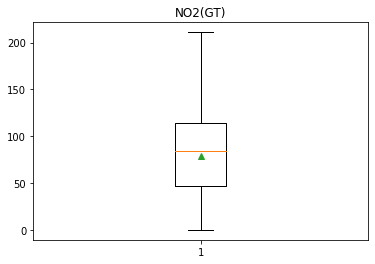

In [14]:
plt.boxplot(train_data['NO2(GT)'],showmeans=True)
plt.title('NO2(GT)')
plt.show()

In [15]:
testing_set=pd.DataFrame(test_data['NO2(GT)'])

In [16]:
#正規化
testing_set_mm=mm.fit_transform(testing_set)

In [17]:
#設定測試資料的timestep
x_test=[]
y_test=[]
for i in range(48,1122):
    x_test.append(testing_set_mm[i-48:i,0])
    y_test.append(testing_set_mm[i,0])
x_test,y_test=np.array(x_test),np.array(y_test)

In [18]:
#將資料升維(二維升三維(aqi,timesteps,indicators))
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [19]:
#進行預測
predict_data=model.predict(x_test)

In [20]:
#將預測資料還原
predict_data=mm.inverse_transform(predict_data)

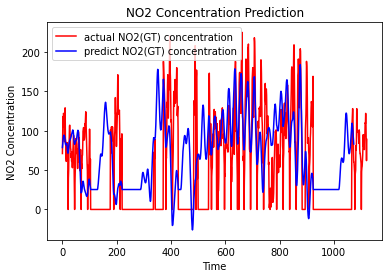

In [21]:
#可視化預測成果
plt.plot(testing_set,color='red',label='actual NO2(GT) concentration')
plt.plot(predict_data,color='blue',label='predict NO2(GT) concentration')
plt.title('NO2 Concentration Prediction')
plt.xlabel('Time')
plt.ylabel('NO2 Concentration')
plt.legend()
plt.show()

In [22]:
#績效評估
print("loss:",model.evaluate(x_train,y_train))
print("mae:",mean_absolute_error(y_test,predict_data))
print("mape:",mean_absolute_percentage_error(y_test,predict_data))
print("rmse:",np.sqrt(mean_squared_error(y_test,predict_data)))

124/124 [==============================] - 4s 32ms/step - loss: 0.0288 - accuracy: 0.1638
loss: [0.028793739154934883, 0.16379310190677643]
mae: 71.93941048421057
mape: 8.63074229398652e+16
rmse: 83.74041854119706
